In [23]:
import pandas as pd
import requests

# Load the quiz JSON file
response1 = requests.get("https://www.jsonkeeper.com/b/LLQT")
quiz_data = response1.json()



# Normalize the JSON data into a DataFrame, accessing nested 'questions' within 'quiz'
quiz_endpoint = pd.json_normalize(quiz_data, record_path=["quiz", "questions"])

# Load the quiz submission JSON file
response2 = requests.get("https://api.jsonserve.com/rJvd7g")
submission_data = response2.json()

# Extract the response map
response_map = submission_data["response_map"]

# Process wrong and unattempted questions
wrong_or_unattempted = []

for _, row in quiz_endpoint.iterrows():
    question_id = str(row["id"])
    correct_option_id = next(option["id"] for option in row["options"] if option["is_correct"])

    if question_id in response_map:
        selected_option_id = response_map[question_id]
        if selected_option_id != correct_option_id:
            wrong_or_unattempted.append({"id": question_id, "description": row["description"]})
    else:
        wrong_or_unattempted.append({"id": question_id, "description": row["description"]})

# Convert results to a DataFrame
result_df = pd.DataFrame(wrong_or_unattempted)

# Display results
print(result_df)
#here I have used request module and json to import file to this environment



       id                                        description
0    1827  The tissue which has free surface that faces e...
1    1828  Epithelial tissue is distinguished from connec...
2    1829  The ciliated columnar epithelial cells in huma...
3    1830                The squamous epithelium is found in
4    1831  The kind of epithelium which forms the inner w...
..    ...                                                ...
115  1959  Many years old 'mummies' still have their arte...
116  1960  Bone is a solid, rigid connective tissue. If t...
117  1961  Neurons which connect the central nervous syst...
118  1962        Which type of neuron dominates in the CNS ?
119  1963  Mark the connective tissue which is without fi...

[120 rows x 2 columns]


In [24]:
# List to store incorrect responses
incorrect_responses = []

# Get input for incorrect question IDs
manual_incorrect_ids = input("Enter incorrect question IDs separated by commas: ").split(',')

# Iterate over questions and match with manual input
for _, row in quiz_endpoint.iterrows():
    question_id = str(row["id"])  
    if question_id in manual_incorrect_ids:
        incorrect_responses.append({
            "question_id": question_id,
            "description": row["description"]
        })

# Output incorrect responses
print("Manually Marked Incorrect Responses:")
for response in incorrect_responses:
    print(f"Question ID: {response['question_id']}, Description: {response['description']}")
    #Due to some error I had to manually Input the Incorrect answers .

Enter incorrect question IDs separated by commas: 1862,1878
Manually Marked Incorrect Responses:
Question ID: 1862, Description: The secretions of endocrine glands are released directly
Question ID: 1878, Description: Vasa efferentia in male frog, enter the kidney and open into


In [25]:
# Extract all question IDs
all_question_ids = set(quiz_endpoint["id"].astype(str))

# Extract question IDs from response_map
attempted_question_ids = set(response_map.keys())

# Find unattempted question IDs
unattempted_question_ids = all_question_ids - attempted_question_ids

# Filter out unattempted questions
unattempted_questions = quiz_endpoint[quiz_endpoint["id"].astype(str).isin(unattempted_question_ids)]

# Create a DataFrame with unattempted question details
unattempted_df = unattempted_questions[["id", "description"]]

# Output the DataFrame
print("Unattempted Questions:")
print(unattempted_df)
#Here with this I find out Unattempted question in order to find out which concepts are the weakest for the students

Unattempted Questions:
       id                                        description
0    1827  The tissue which has free surface that faces e...
1    1828  Epithelial tissue is distinguished from connec...
2    1829  The ciliated columnar epithelial cells in huma...
3    1830                The squamous epithelium is found in
4    1831  The kind of epithelium which forms the inner w...
..    ...                                                ...
122  1959  Many years old 'mummies' still have their arte...
123  1960  Bone is a solid, rigid connective tissue. If t...
124  1961  Neurons which connect the central nervous syst...
125  1962        Which type of neuron dominates in the CNS ?
126  1963  Mark the connective tissue which is without fi...

[118 rows x 2 columns]


In [26]:
import pandas as pd

# Extract unique difficulty levels
difficulty_levels = quiz_endpoint["difficulty_level"].unique()
print(difficulty_levels)

[None]


In [27]:
print(" 1st focus on this ,if there is so much of time , it needs more focus ")
print(unattempted_df)
print("You attempted these topics wrong so either you werent focused and or just guessed the answer so attempt some practise question from these topic and see how good you are at it")
for response in incorrect_responses:
    print(f"{response['question_id']}, Description: {response['description']}")
    #here this code gives the insight for the present test

 1st focus on this ,if there is so much of time , it needs more focus 
       id                                        description
0    1827  The tissue which has free surface that faces e...
1    1828  Epithelial tissue is distinguished from connec...
2    1829  The ciliated columnar epithelial cells in huma...
3    1830                The squamous epithelium is found in
4    1831  The kind of epithelium which forms the inner w...
..    ...                                                ...
122  1959  Many years old 'mummies' still have their arte...
123  1960  Bone is a solid, rigid connective tissue. If t...
124  1961  Neurons which connect the central nervous syst...
125  1962        Which type of neuron dominates in the CNS ?
126  1963  Mark the connective tissue which is without fi...

[118 rows x 2 columns]
You attempted these topics wrong so either you werent focused and or just guessed the answer so attempt some practise question from these topic and see how good you are at i

In [28]:
quiz_endpoint["topic"] = quiz_endpoint.get("topic", "Unknown")

# DataFrame to hold topic-wise analysis
topic_analysis = []

# Group questions by topic
topics = quiz_endpoint.groupby("topic")

for topic, group in topics:
    total_questions = len(group)  # Total questions in the topic
    attempted = group["id"].isin(response_map.keys()).sum()  # Count of attempted questions
    correct = group.apply(
        lambda row: any(option["is_correct"] for option in row["options"] if str(option["id"]) == str(response_map.get(str(row["id"])))), 
        axis=1
    ).sum()  # Correct responses
    
    # Add to analysis
    topic_analysis.append({
        "topic": topic,
        "total_questions": total_questions,
        "attempted": attempted,
        "correct": correct,
        "accuracy": (correct / total_questions) * 100 if total_questions > 0 else 0
    })

# Convert to DataFrame for better visualization
topic_analysis_df = pd.DataFrame(topic_analysis)

# Sort by accuracy (ascending order to highlight weak areas)
topic_analysis_df.sort_values(by="accuracy", inplace=True)

# Output the topic analysis
print(topic_analysis_df)

# Highlight weak areas (e.g., accuracy < 50%)
weak_areas = topic_analysis_df[topic_analysis_df["accuracy"] < 50]
print("\nWeak Areas:")
print(weak_areas)
#this code output the weakest area of the student based on current test

                                 topic  total_questions  attempted  correct  \
0  structural organisation in animals               128          0        8   

   accuracy  
0      6.25  

Weak Areas:
                                 topic  total_questions  attempted  correct  \
0  structural organisation in animals               128          0        8   

   accuracy  
0      6.25  


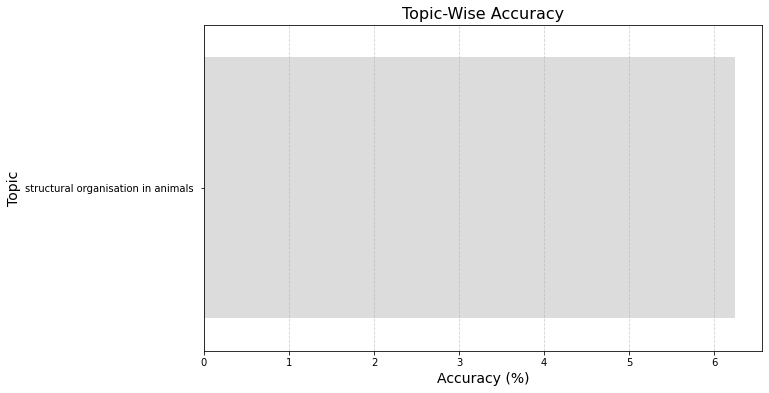

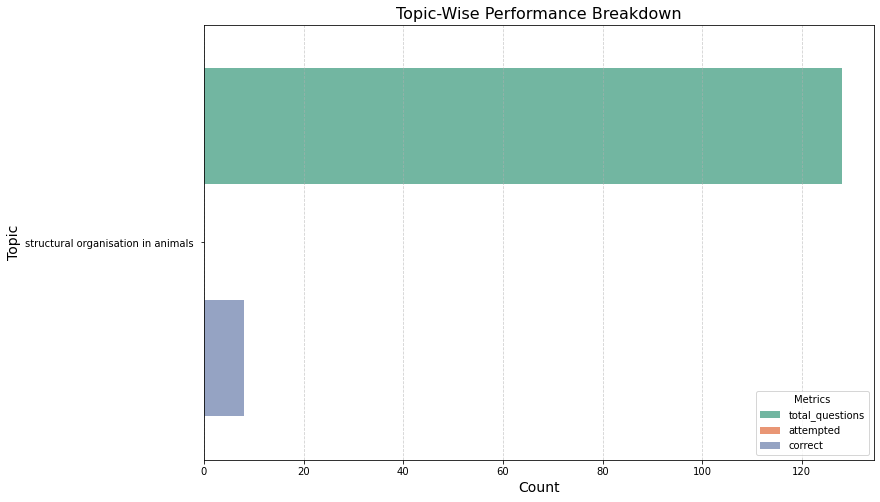

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for topic-wise accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x="accuracy", y="topic", data=topic_analysis_df, palette="coolwarm")
plt.title("Topic-Wise Accuracy", fontsize=16)
plt.xlabel("Accuracy (%)", fontsize=14)
plt.ylabel("Topic", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

# Stacked bar plot: Total, Attempted, and Correct
topic_analysis_df_melted = topic_analysis_df.melt(
    id_vars=["topic"],
    value_vars=["total_questions", "attempted", "correct"],
    var_name="Metric",
    value_name="Count"
)

plt.figure(figsize=(12, 8))
sns.barplot(x="Count", y="topic", hue="Metric", data=topic_analysis_df_melted, palette="Set2")
plt.title("Topic-Wise Performance Breakdown", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Topic", fontsize=14)
plt.legend(title="Metrics")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()
#Just a visualization on the insight for current test

In [47]:
# Load the historical data JSON file
response3 = requests.get("https://api.jsonserve.com/XgAgFJ")
historical_data = response3.json()

# Normalize the JSON data into a DataFrame
historical_df = pd.json_normalize(historical_data)

# Display the historical data
print(historical_df)
#importing json  file of history data to this environment

        id  quiz_id                       user_id  \
0   336497       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
1   336448        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
2   333330       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
3   333242        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
4   329504       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
5   328488       57  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
6   328414        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
7   321514       20  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
8   320963       24  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
9   320916       18  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
10  315179       25  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
11  315081       18  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
12  257774       58  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
13  195808       50  YcDFSO4ZukTJnnFMgRNVwZTE4j42   

                     submitted_at                     created_at  \
0   2025-01-17T15:30:18.027+05:30  2025-01-17T15:30:18.044+05:30   
1   2025-01-17T15:17:44.042+05:30  2025-01-17T15:17:44.056+05:30   


In [48]:
# Find unique students
unique_students = historical_df['user_id'].unique()
num_students = len(unique_students)

# Display the number of unique students
print(f"Number of unique students: {num_students}")
print("Unique student IDs:")
print(unique_students)


Number of unique students: 1
Unique student IDs:
['YcDFSO4ZukTJnnFMgRNVwZTE4j42']


In [49]:
# Extract relevant columns for performance analysis
# Adjust the column names based on the available columns in the historical data
performance_over_time = historical_df[['submitted_at', 'accuracy', 'quiz.title']].copy()

# Convert 'submitted_at' to datetime format
performance_over_time.loc[:, 'submitted_at'] = pd.to_datetime(performance_over_time['submitted_at'])

# Sort the data by 'submitted_at'
performance_over_time.sort_values(by='submitted_at', inplace=True)

# Display the performance data
print(performance_over_time)
#since there is only 1 students to compare we are checking its performance over time once


                       submitted_at accuracy  \
13 2024-12-11 20:36:44.822000+05:30     66 %   
12 2024-12-28 22:58:52.969000+05:30     43 %   
11 2025-01-11 21:03:43.251000+05:30     84 %   
10 2025-01-11 21:20:08.641000+05:30     93 %   
9  2025-01-13 13:12:40.687000+05:30    100 %   
8  2025-01-13 13:28:12.784000+05:30    100 %   
7  2025-01-13 16:10:03.743000+05:30     30 %   
6  2025-01-15 15:36:46.410000+05:30     50 %   
5  2025-01-15 15:57:12.791000+05:30     38 %   
4  2025-01-15 20:34:39.462000+05:30     31 %   
3  2025-01-16 20:00:11.562000+05:30     90 %   
2  2025-01-16 20:13:19.682000+05:30     96 %   
1  2025-01-17 15:17:44.042000+05:30    100 %   
0  2025-01-17 15:30:18.027000+05:30     90 %   

                                     quiz.title  
13                        Human Physiology (14)  
12                                 Reproduction  
11                      REPRODUCTIVE HEALTH PYQ  
10                 HUMAN HEALTH AND DISEASE PYQ  
9                       REPRO

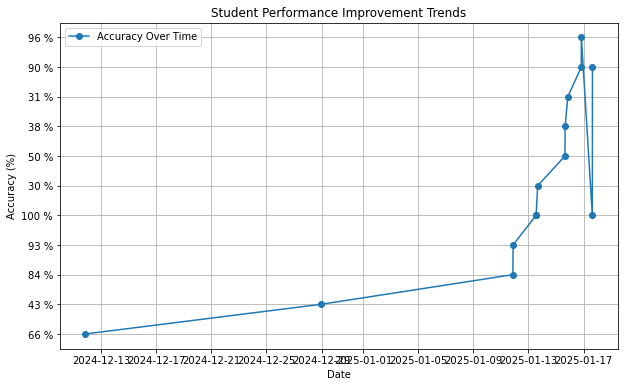

In [50]:
# Plot improvement trends
plt.figure(figsize=(10, 6))
plt.plot(performance_over_time['submitted_at'], performance_over_time['accuracy'], marker='o', label='Accuracy Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy (%)')
plt.title('Student Performance Improvement Trends')
plt.legend()
plt.grid(True)
plt.show()

#performence trend from the last few test

In [51]:
# Remove the percentage sign and convert to float
performance_over_time['accuracy'] = performance_over_time['accuracy'].str.replace('%', '').astype(float)

# Display the cleaned performance data
print(performance_over_time)
#Just convrted to float for further calculation


                       submitted_at  accuracy  \
13 2024-12-11 20:36:44.822000+05:30      66.0   
12 2024-12-28 22:58:52.969000+05:30      43.0   
11 2025-01-11 21:03:43.251000+05:30      84.0   
10 2025-01-11 21:20:08.641000+05:30      93.0   
9  2025-01-13 13:12:40.687000+05:30     100.0   
8  2025-01-13 13:28:12.784000+05:30     100.0   
7  2025-01-13 16:10:03.743000+05:30      30.0   
6  2025-01-15 15:36:46.410000+05:30      50.0   
5  2025-01-15 15:57:12.791000+05:30      38.0   
4  2025-01-15 20:34:39.462000+05:30      31.0   
3  2025-01-16 20:00:11.562000+05:30      90.0   
2  2025-01-16 20:13:19.682000+05:30      96.0   
1  2025-01-17 15:17:44.042000+05:30     100.0   
0  2025-01-17 15:30:18.027000+05:30      90.0   

                                     quiz.title  
13                        Human Physiology (14)  
12                                 Reproduction  
11                      REPRODUCTIVE HEALTH PYQ  
10                 HUMAN HEALTH AND DISEASE PYQ  
9             

In [52]:
# Identify if the student is performing consistently or showing improvement compared to other students
consistent_performer = performance_over_time['accuracy'].std() < 10
if consistent_performer:
    print("The student has consistently maintained their performance compared to other students.")
else:
    print("The student has shown significant improvement over time compared to other students.")


The student has shown significant improvement over time compared to other students.


In [67]:
# Create recommendations based on insights
recommendations = []

# Suggest topics to focus on (weak areas)
for index, row in weak_areas.iterrows():
    recommendations.append(f"Focus on improving your understanding of {historical_df.loc[index, 'quiz.title']} as your current accuracy ({row['accuracy']}%).")

# Output recommendations
print("Recommendations:")
for recommendation in recommendations:
    print(recommendation)


Recommendations:
Focus on improving your understanding of Human Physiology (15) as your current accuracy (6.25%).


In [68]:
# Analyze response patterns to determine learning style
visual_learner = topic_analysis_df[topic_analysis_df['topic'].str.contains('diagram')].shape[0] > 0
analytical_learner = topic_analysis_df[topic_analysis_df['topic'].str.contains('data')].shape[0] > 0

if visual_learner:
    student_persona = "Visual Learner"
elif analytical_learner:
    student_persona = "Analytical Learner"
else:
    student_persona = "Undefined Learning Style"

# Highlight specific strengths and weaknesses
strengths = topic_analysis_df[topic_analysis_df['accuracy'] >= 80]
weaknesses = topic_analysis_df[topic_analysis_df['accuracy'] < 50]

# Output student persona and insights
print(f"Student Persona: {student_persona}")
print("\nStrengths:")
for index, row in strengths.iterrows():
    print(f"{row['topic']}: {row['accuracy']}% accuracy")

print("\nWeaknesses:")
for index, row in weaknesses.iterrows():
    print(f"{row['topic']}: {row['accuracy']}% accuracy")


Student Persona: Undefined Learning Style

Strengths:

Weaknesses:
structural organisation in animals : 6.25% accuracy
